# Machine Learning of Elo Merchant Category Recommendation Competition

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time
import datetime

import warnings
warnings.filterwarnings("ignore")

from sklearn import model_selection, preprocessing, metrics
from sklearn.model_selection import StratifiedKFold,KFold
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import gc

In [2]:
train_df = pd.read_csv('../train.csv', parse_dates=["first_active_month"])
test_df = pd.read_csv('../test.csv', parse_dates=["first_active_month"])

print("Training data size",train_df.shape)
print("Testing data size",test_df.shape)

Training data size (201917, 6)
Testing data size (123623, 5)


In [3]:
hist_df = pd.read_csv('../historical_transactions.csv')
new_df = pd.read_csv("../new_merchant_transactions.csv")

In [ ]:
hd = {'Unique Entry': hist_df.nunique(axis = 0),
        'Nan Entry': hist_df.isnull().any()}
pd.DataFrame(data = hd, index = hist_df.columns.values)

In [4]:
#for df in [hist_df,new_df]:
#    df['category_2'].fillna(1.0,inplace=True)
#    df['category_3'].fillna('A',inplace=True)
#    df['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)
for df in [hist_df,new_df]:
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['year'] = df['purchase_date'].dt.year
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['month'] = df['purchase_date'].dt.month
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    df['hour'] = df['purchase_date'].dt.hour
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0}) 
    #https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/73244
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']

In [5]:
hist_df = pd.get_dummies(hist_df,columns=['category_2','category_3'])
new_df = pd.get_dummies(new_df,columns=['category_2','category_3'])

In [6]:
def aggregate_historical_transactions(history):
    
    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).\
                                      astype(np.int64) * 1e-9
    
    agg_func = {
        'category_1': ['sum', 'mean'],
        'category_2_1.0': ['mean'],
        'category_2_2.0': ['mean'],
        'category_2_3.0': ['mean'],
        'category_2_4.0': ['mean'],
        'category_2_5.0': ['mean'],
        'category_3_A': ['mean'],
        'category_3_B': ['mean'],
        'category_3_C': ['mean'],
        'merchant_id': ['nunique'],
        'merchant_category_id':['nunique'],
        'state_id':['nunique'],
        'city_id': ['nunique'],
        'subsector_id':['nunique'],
        'weekofyear':['nunique'],
        'year':['nunique'],
        'weekend':['sum','mean'],
        # non-categorical features
        'purchase_amount': ['sum', 'median', 'max', 'min', 'std'],
        'installments': ['sum', 'median', 'max', 'min', 'std'],
        'purchase_date': [np.ptp],
        'month_lag': ['min', 'max'],
        'month_diff':['mean'],
        'authorized_flag': ['sum', 'mean'],

        }
    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['_'.join(col).strip() 
                           for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    df = (history.groupby('card_id')
          .size()
          .reset_index(name='hist_transactions_count'))
    
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    
    return agg_history

In [7]:
history = aggregate_historical_transactions(hist_df)
history.columns = ['hist_' + c if c != 'card_id' else c for c in history.columns]
del hist_df
#gc.collect()
history[:5]

,card_id,hist_hist_transactions_count,hist_category_1_sum,hist_category_1_mean,hist_category_2_1.0_mean,hist_category_2_2.0_mean,hist_category_2_3.0_mean,hist_category_2_4.0_mean,hist_category_2_5.0_mean,hist_category_3_A_mean,...,hist_installments_median,hist_installments_max,hist_installments_min,hist_installments_std,hist_purchase_date_ptp,hist_month_lag_min,hist_month_lag_max,hist_month_diff_mean,hist_authorized_flag_sum,hist_authorized_flag_mean
0,C_ID_00007093c1,149,28,0.187919,0.000000,0.000000,0.805369,0.0,0.006711,0.000000,...,1.0,6,1,0.764900,32627654.0,-12,0,10.348993,114,0.765101
1,C_ID_0001238066,123,2,0.016260,0.772358,0.000000,0.000000,0.0,0.162602,0.000000,...,1.0,10,-1,1.485637,13110825.0,-5,0,10.178862,120,0.975610
2,C_ID_0001506ef0,66,0,0.000000,0.030303,0.000000,0.969697,0.0,0.000000,0.984848,...,0.0,1,0,0.123091,34460275.0,-13,0,10.257576,62,0.939394
3,C_ID_0001793786,216,2,0.009259,0.050926,0.351852,0.069444,0.0,0.000000,0.976852,...,0.0,1,0,0.150723,24487497.0,-9,0,14.189815,189,0.875000
4,C_ID_000183fdda,144,4,0.027778,0.048611,0.006944,0.909722,0.0,0.006944,0.000000,...,1.0,10,-1,2.118846,17492874.0,-6,0,10.187500,137,0.951389


In [8]:
new = aggregate_historical_transactions(new_df)
new.columns = ['new_' + c if c != 'card_id' else c for c in new.columns]
del new_df
#gc.collect()
new[:5]

,card_id,new_hist_transactions_count,new_category_1_sum,new_category_1_mean,new_category_2_1.0_mean,new_category_2_2.0_mean,new_category_2_3.0_mean,new_category_2_4.0_mean,new_category_2_5.0_mean,new_category_3_A_mean,...,new_installments_median,new_installments_max,new_installments_min,new_installments_std,new_purchase_date_ptp,new_month_lag_min,new_month_lag_max,new_month_diff_mean,new_authorized_flag_sum,new_authorized_flag_mean
0,C_ID_00007093c1,2,0,0.000000,0.500000,0.000000,0.50000,0.0,0.000000,0.0,...,1.0,1,1,0.000000,537024.0,2,2,10.500000,2,1
1,C_ID_0001238066,26,2,0.076923,0.769231,0.000000,0.00000,0.0,0.115385,0.0,...,1.0,10,-1,2.079941,5195343.0,1,2,10.153846,26,1
2,C_ID_0001506ef0,2,0,0.000000,0.000000,0.000000,1.00000,0.0,0.000000,1.0,...,0.0,0,0,0.000000,471152.0,1,1,10.000000,2,1
3,C_ID_0001793786,31,0,0.000000,0.483871,0.258065,0.16129,0.0,0.032258,1.0,...,0.0,0,0,0.000000,3981096.0,1,2,14.000000,31,1
4,C_ID_000183fdda,11,0,0.000000,0.000000,0.000000,1.00000,0.0,0.000000,0.0,...,1.0,4,-1,1.293340,5106807.0,1,2,10.363636,11,1


## Training the model

In [9]:
train_df = pd.merge(train_df, history, on='card_id', how='left')
test_df = pd.merge(test_df, history, on='card_id', how='left')

train_df = pd.merge(train_df, new, on='card_id', how='left')
test_df = pd.merge(test_df, new, on='card_id', how='left')

In [ ]:
train_df["year"] = train_df["first_active_month"].dt.year
test_df["year"] = test_df["first_active_month"].dt.year
train_df["month"] = train_df["first_active_month"].dt.month
test_df["month"] = test_df["first_active_month"].dt.month

In [10]:
test_df.to_csv('../test_base.csv')
train_df.to_csv('../train_base.csv')
target = train_df['target']
del train_df['target']

In [11]:
features = [c for c in train_df.columns if c not in ['card_id', 'first_active_month']]
#features = [f for f in features if f not in unimportant_features]
categorical_feats = ['feature_2', 'feature_3']

https://www.kaggle.com/fabiendaniel/hyperparameter-tuning

In [12]:
param = {'num_leaves': 111,
         'min_data_in_leaf': 149, 
         'objective':'regression',
         'max_depth': 9,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}

In [16]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train_df.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.72196	valid_1's rmse: 3.78074
[200]	training's rmse: 3.65765	valid_1's rmse: 3.73382
[300]	training's rmse: 3.61733	valid_1's rmse: 3.71064
[400]	training's rmse: 3.58924	valid_1's rmse: 3.69828
[500]	training's rmse: 3.56757	valid_1's rmse: 3.69072
[600]	training's rmse: 3.54909	valid_1's rmse: 3.68619
[700]	training's rmse: 3.53424	valid_1's rmse: 3.68356
[800]	training's rmse: 3.52106	valid_1's rmse: 3.68178
[900]	training's rmse: 3.50963	valid_1's rmse: 3.6804
[1000]	training's rmse: 3.49867	valid_1's rmse: 3.67947
[1100]	training's rmse: 3.48873	valid_1's rmse: 3.67886
[1200]	training's rmse: 3.47897	valid_1's rmse: 3.67849
[1300]	training's rmse: 3.46953	valid_1's rmse: 3.67799
[1400]	training's rmse: 3.46101	valid_1's rmse: 3.67784
[1500]	training's rmse: 3.4521	valid_1's rmse: 3.67793
[1600]	training's rmse: 3.44331	valid_1's rmse: 3.6781
Early stopping, best iteration is:
[1458]	tr

## Feature importance

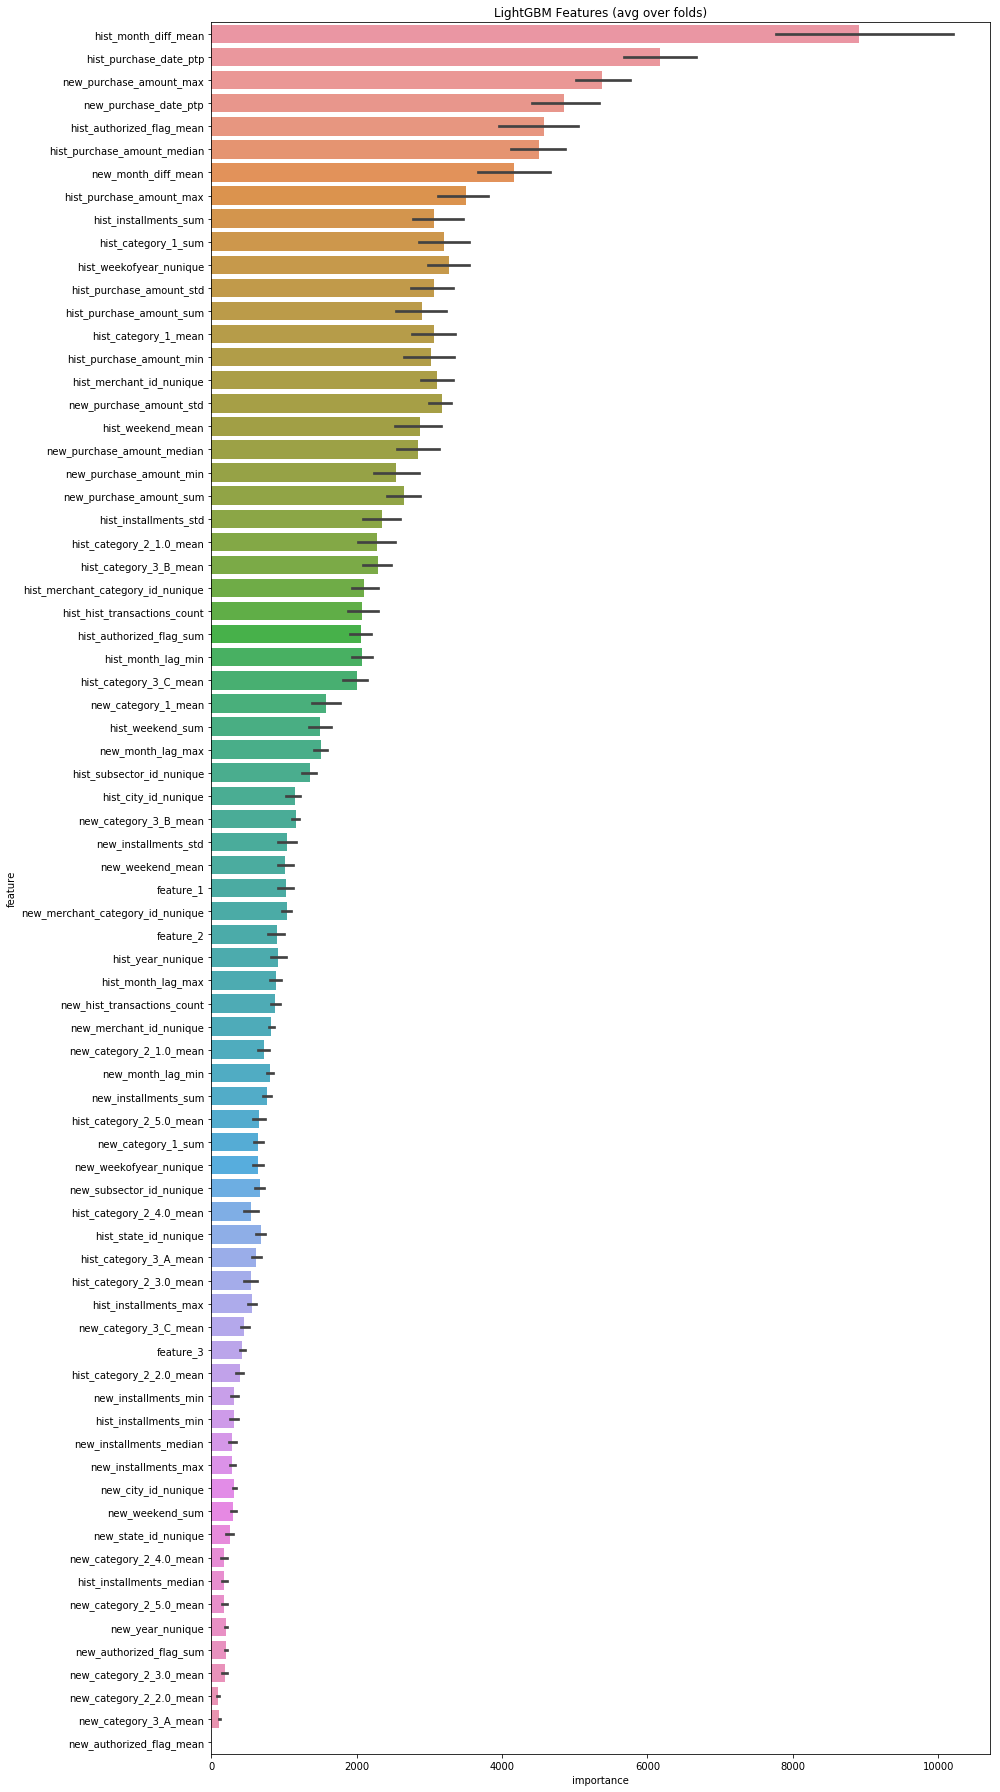

In [17]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
#plt.savefig('lgbm_importances.png')
plt.show()

## Submission

In [19]:
sub_df = pd.DataFrame({"card_id":test_df["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("../submit_base.csv", index=False)